<a href="https://colab.research.google.com/github/KaustubhKaushik26/Sentiment-Analysis/blob/main/SentimentAnalysis_with_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plan of Action


1.   Load **IMDb Movie Reviews dataset (50,000 reviews)**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN and LSTM Models** and analyse model performance and results
4. Last, perform **predictions on real IMDb movie reviews**

## Setting the environment

In [1]:
import tensorflow as tf
from tensorflow import keras


In [2]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM


from sklearn.model_selection import train_test_split

## Loading dataset

In [5]:
# Importing IMDb Movie Reviews dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/SentimentAnalysis/dataset/IMDB Dataset.csv'

movie_reviews = pd.read_csv(dataset_path)

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [7]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
# Checking for missing values

movie_reviews.isnull().values.any()

np.False_

<Axes: xlabel='sentiment', ylabel='count'>

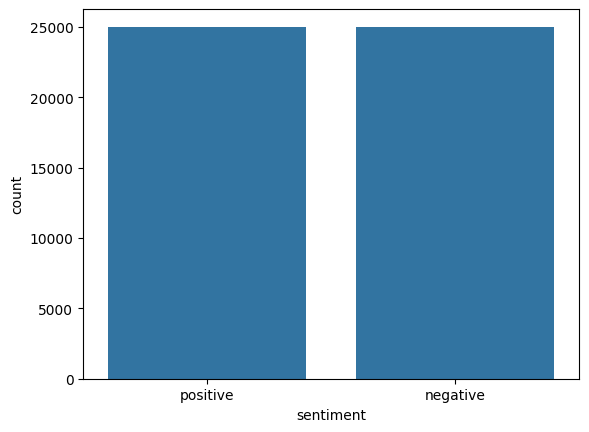

In [9]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [10]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [11]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [32]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [33]:
# Sample cleaned up movie review

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [34]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [36]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [37]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [38]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Loading Glove Embedding

In [39]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_embedding_path = '/content/drive/MyDrive/Colab Notebooks/SentimentAnalysis/dataset/glove.6B.100d.txt'
glove_file = open(glove_embedding_path, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [40]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [23]:
embedding_matrix.shape

(92394, 100)

## Loading FastText Embedding

In [24]:
# Load FastText .vec file
fasttext_embedding_index = {}

fasttext_embedding_path = '/content/drive/MyDrive/Colab Notebooks/SentimentAnalysis/dataset/wiki-news-300d-1M.vec'

with open(fasttext_embedding_path, 'r', encoding='utf-8', errors='ignore') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        fasttext_embedding_index[word] = vector


In [25]:
# Create FastText embedding matrix of shape (vocab_length, 300)
fasttext_embedding_matrix = np.zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
    vector = fasttext_embedding_index.get(word)
    if vector is not None:
        fasttext_embedding_matrix[index] = vector


# Model Training with:

# 1(a). Simple Neural Network with Glove Embedding

In [41]:
# Neural Network architecture

glove_snn_model = Sequential()
glove_embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

glove_snn_model.add(glove_embedding_layer)

glove_snn_model.add(Flatten())
glove_snn_model.add(Dense(1, activation='sigmoid'))
# Model compiling

glove_snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [44]:


print(glove_snn_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (128, 100, 100)        │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (128, 10000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (128, 1)               │        10,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,269,405 (35.36 MB)

 Trainable params: 10,001 (39.07 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

 Optimizer params: 20,004 (78.14 KB)

None


In [43]:
# Model training

glove_snn_model_history = glove_snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - acc: 0.6732 - loss: 0.6023 - val_acc: 0.7624 - val_loss: 0.5026
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.8033 - loss: 0.4409 - val_acc: 0.7644 - val_loss: 0.4950
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8202 - loss: 0.4080 - val_acc: 0.7586 - val_loss: 0.5176
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8319 - loss: 0.3831 - val_acc: 0.7610 - val_loss: 0.5097
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8469 - loss: 0.3567 - val_acc: 0.7615 - val_loss: 0.5280
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8545 - loss: 0.3470 - val_acc: 0.7577 - val_loss: 0.5328


In [45]:
# Predictions on the Test Set

glove_snn_score = glove_snn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7459 - loss: 0.5551


In [46]:
# Model Performance

print("Test Score:", glove_snn_score[0])
print("Test Accuracy:", glove_snn_score[1])

Test Score: 0.5571328401565552
Test Accuracy: 0.7511000037193298


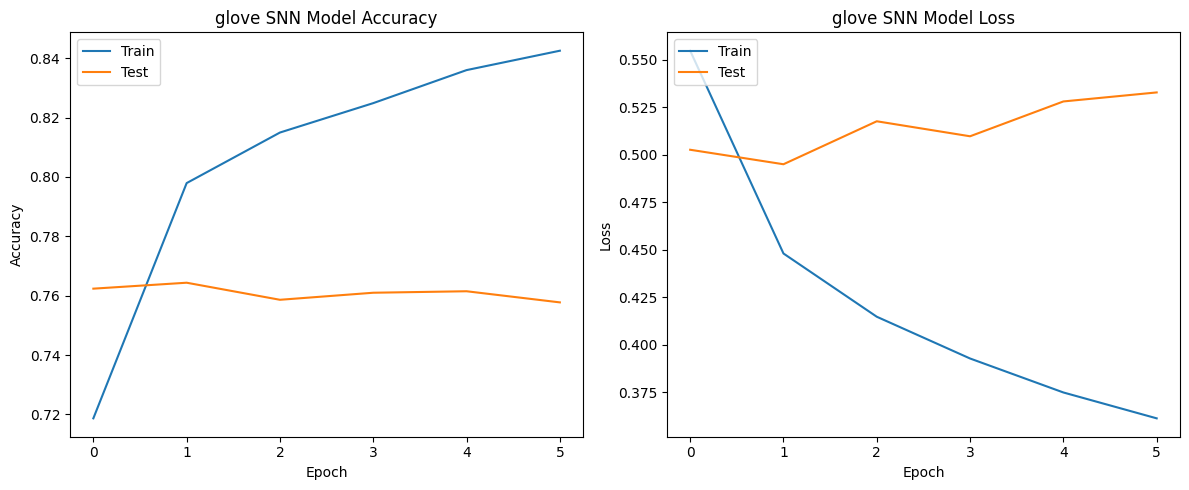

In [48]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # You can adjust the figsize as needed

# Accuracy plot
axs[0].plot(glove_snn_model_history.history['acc'])
axs[0].plot(glove_snn_model_history.history['val_acc'])
axs[0].set_title('glove SNN Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Loss plot
axs[1].plot(glove_snn_model_history.history['loss'])
axs[1].plot(glove_snn_model_history.history['val_loss'])
axs[1].set_title('glove SNN Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# 1(b). Simple Neural Network with Fasttext Embedding

In [51]:
fasttext_snn_model = Sequential()
fasttext_snn_model.add(Embedding(vocab_length, 300, weights=[fasttext_embedding_matrix], input_length=maxlen, trainable=False))
fasttext_snn_model.add(Flatten())
fasttext_snn_model.add(Dense(1, activation='sigmoid'))

fasttext_snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])



In [53]:
# Model Summary
fasttext_snn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (128, 100, 300)        │    27,718,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (128, 30000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (128, 1)               │        30,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,808,205 (106.08 MB)

 Trainable params: 30,001 (117.19 KB)

 Non-trainable params: 27,718,200 (105.74 MB)

 Optimizer params: 60,004 (234.39 KB)

In [52]:
# Model Training
fasttext_snn_model_history = fasttext_snn_model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - acc: 0.7119 - loss: 0.5831 - val_acc: 0.8077 - val_loss: 0.4534
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8558 - loss: 0.3815 - val_acc: 0.8305 - val_loss: 0.4082
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8882 - loss: 0.3184 - val_acc: 0.8331 - val_loss: 0.3944
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9081 - loss: 0.2780 - val_acc: 0.8301 - val_loss: 0.3913
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9226 - loss: 0.2473 - val_acc: 0.8309 - val_loss: 0.3925
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9348 - loss: 0.2242 - val_acc: 0.8270 - val_loss: 0.3970


In [54]:
# Predictions on the Test Set

fasttext_snn_score = fasttext_snn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8173 - loss: 0.4133


In [55]:
# Model Performance

print("Test Score:", fasttext_snn_score[0])
print("Test Accuracy:", fasttext_snn_score[1])

Test Score: 0.4117664694786072
Test Accuracy: 0.8170999884605408


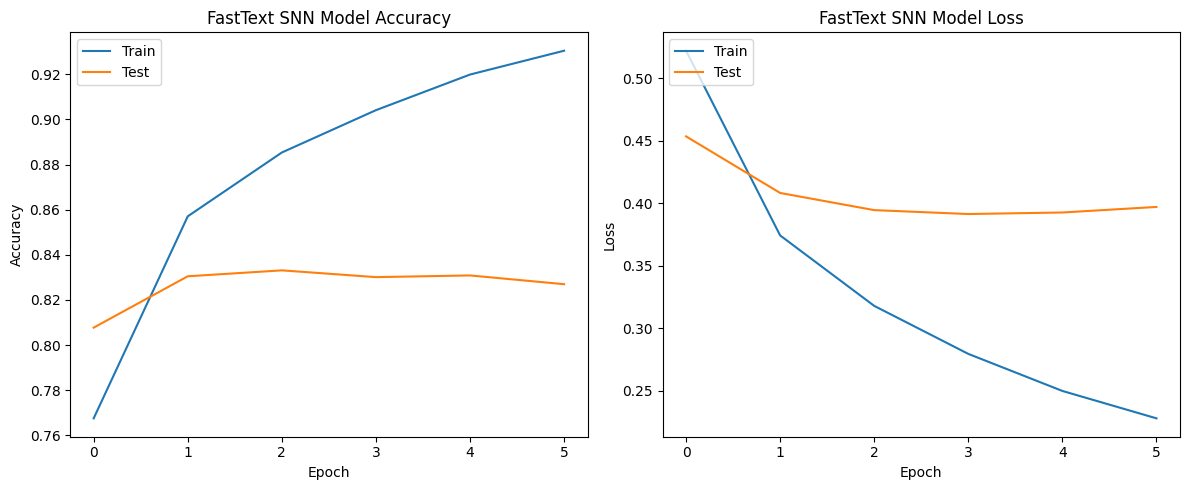

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axs[0].plot(fasttext_snn_model_history.history['acc'])
axs[0].plot(fasttext_snn_model_history.history['val_acc'])
axs[0].set_title('FastText SNN Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Loss plot
axs[1].plot(fasttext_snn_model_history.history['loss'])
axs[1].plot(fasttext_snn_model_history.history['val_loss'])
axs[1].set_title('FastText SNN Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Test'], loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

# 2(a). Convolutional Neural Network with Glove Embedding

In [57]:
from keras.layers import Conv1D

In [58]:
# Neural Network architecture

glove_cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
glove_cnn_model.add(embedding_layer)

glove_cnn_model.add(Conv1D(128, 5, activation='relu'))
glove_cnn_model.add(GlobalMaxPooling1D())
glove_cnn_model.add(Dense(1, activation='sigmoid'))

In [59]:
# Model compiling

glove_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [60]:
# Model training

glove_cnn_model_history = glove_cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - acc: 0.7090 - loss: 0.5470 - val_acc: 0.8338 - val_loss: 0.3735
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - acc: 0.8567 - loss: 0.3370 - val_acc: 0.8479 - val_loss: 0.3421
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8916 - loss: 0.2781 - val_acc: 0.8525 - val_loss: 0.3315
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9145 - loss: 0.2374 - val_acc: 0.8526 - val_loss: 0.3450
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.9374 - loss: 0.1939 - val_acc: 0.8530 - val_loss: 0.3384
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9521 - loss: 0.1644 - val_acc: 0.8536 - val_loss: 0.3443


In [61]:
# Model Summary
print(glove_cnn_model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (128, 100, 100)        │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (128, 96, 128)         │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (128, 128)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,432,173 (35.98 MB)

 Trainable params: 64,257 (251.00 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

 Optimizer params: 128,516 (502.02 KB)

None


In [62]:
# Predictions on the Test Set

glove_cnn_score = glove_cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8488 - loss: 0.3548


In [63]:
# Model Performance

print("Test Score:", glove_cnn_score[0])
print("Test Accuracy:", glove_cnn_score[1])

Test Score: 0.3568938076496124
Test Accuracy: 0.8468000292778015


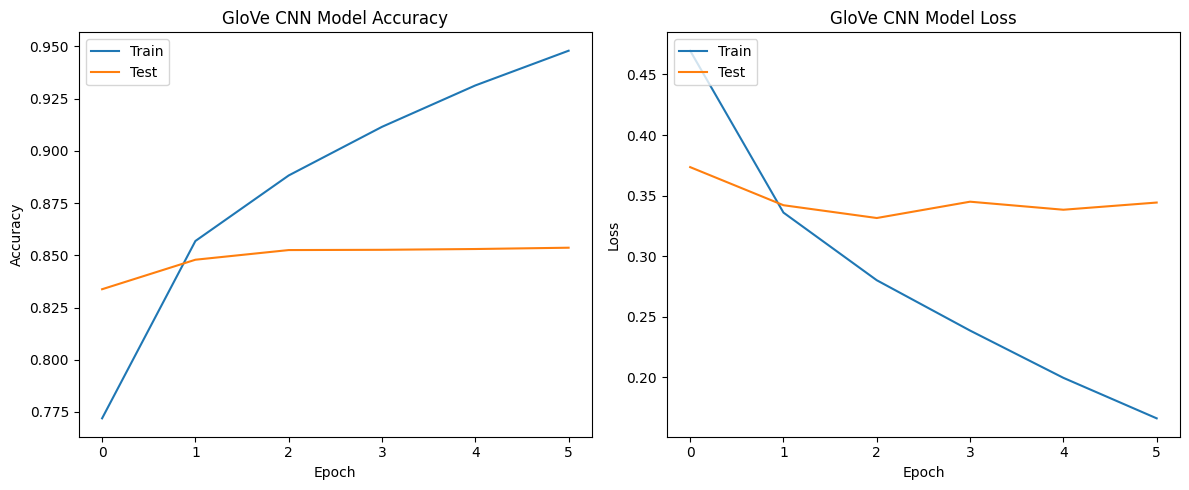

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axs[0].plot(glove_cnn_model_history.history['acc'])
axs[0].plot(glove_cnn_model_history.history['val_acc'])
axs[0].set_title('GloVe CNN Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Loss plot
axs[1].plot(glove_cnn_model_history.history['loss'])
axs[1].plot(glove_cnn_model_history.history['val_loss'])
axs[1].set_title('GloVe CNN Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Test'], loc='upper left')

# Layout adjustment
plt.tight_layout()
plt.show()

# 2(b). Convolutional Neural Network with Fasttext Embedding

In [65]:
fasttext_cnn_model = Sequential()
fasttext_cnn_model.add(Embedding(vocab_length, 300, weights=[fasttext_embedding_matrix], input_length=maxlen, trainable=False))
fasttext_cnn_model.add(Conv1D(128, 5, activation='relu'))
fasttext_cnn_model.add(GlobalMaxPooling1D())
fasttext_cnn_model.add(Dense(1, activation='sigmoid'))

fasttext_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [66]:
# Training Model
fasttext_cnn_model_history = fasttext_cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - acc: 0.7575 - loss: 0.5055 - val_acc: 0.8593 - val_loss: 0.3249
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - acc: 0.8826 - loss: 0.2905 - val_acc: 0.8730 - val_loss: 0.3010
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.9143 - loss: 0.2325 - val_acc: 0.8774 - val_loss: 0.2905
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.9401 - loss: 0.1847 - val_acc: 0.8795 - val_loss: 0.2851
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.9609 - loss: 0.1422 - val_acc: 0.8805 - val_loss: 0.2894
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc: 0.9756 - loss: 0.1061 - val_acc: 0.8781 - val_loss: 0.2913


In [67]:
fasttext_cnn_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (128, 100, 300)        │    27,718,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (128, 96, 128)         │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (128, 128)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,294,973 (107.94 MB)

 Trainable params: 192,257 (751.00 KB)

 Non-trainable params: 27,718,200 (105.74 MB)

 Optimizer params: 384,516 (1.47 MB)

In [68]:
# Predictions on the Test Set

fasttext_cnn_score = glove_cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8488 - loss: 0.3548


In [69]:
# Model Performance

print("Fasttext CNN Test Score:", fasttext_cnn_score[0])
print("Fasttext CNN Test Accuracy:", fasttext_cnn_score[1])

Fasttext CNN Test Score: 0.3568938076496124
Fasttext CNN Test Accuracy: 0.8468000292778015


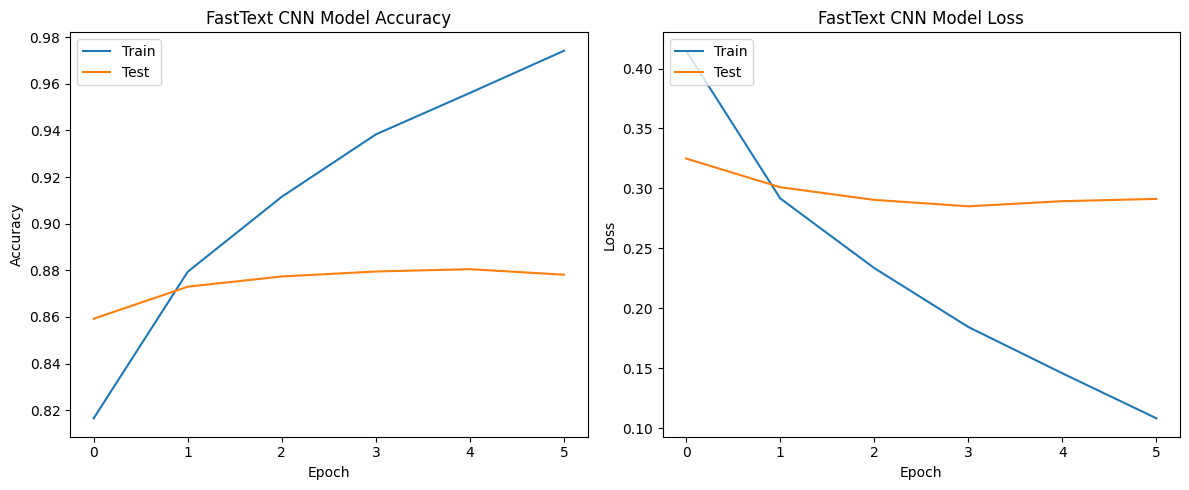

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axs[0].plot(fasttext_cnn_model_history.history['acc'])
axs[0].plot(fasttext_cnn_model_history.history['val_acc'])
axs[0].set_title('FastText CNN Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Loss plot
axs[1].plot(fasttext_cnn_model_history.history['loss'])
axs[1].plot(fasttext_cnn_model_history.history['val_loss'])
axs[1].set_title('FastText CNN Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Test'], loc='upper left')

# Adjust layout for clarity
plt.tight_layout()
plt.show()

# 3(a). Recurrent Neural Network (LSTM) with Glove Embedding

In [71]:
from keras.layers import LSTM

In [72]:
# Neural Network architecture

glove_lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

glove_lstm_model.add(embedding_layer)
glove_lstm_model.add(LSTM(128))

glove_lstm_model.add(Dense(1, activation='sigmoid'))

In [73]:
# Model compiling

glove_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [74]:
# Model Training

glove_lstm_model_history = glove_lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - acc: 0.6657 - loss: 0.5924 - val_acc: 0.7883 - val_loss: 0.4635
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.8046 - loss: 0.4317 - val_acc: 0.8330 - val_loss: 0.3797
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.8237 - loss: 0.3975 - val_acc: 0.8396 - val_loss: 0.3595
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.8457 - loss: 0.3561 - val_acc: 0.8338 - val_loss: 0.3844
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.8595 - loss: 0.3279 - val_acc: 0.8680 - val_loss: 0.3185
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - acc: 0.8732 - loss: 0.3029 - val_acc: 0.8665 - val_loss: 0.3183


In [75]:
print(glove_lstm_model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (128, 100, 100)        │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (128, 128)             │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,591,533 (36.59 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

 Optimizer params: 234,756 (917.02 KB)

None


In [76]:
# Predictions on the Test Set

glove_LSTM_score = glove_lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.8657 - loss: 0.3195


In [77]:
# Model Performance

print("Glove LSTM Test Score:", glove_LSTM_score[0])
print("Glove LSTM Test Accuracy:", glove_LSTM_score[1])

Glove LSTM Test Score: 0.3235744535923004
Glove LSTM Test Accuracy: 0.8637999892234802


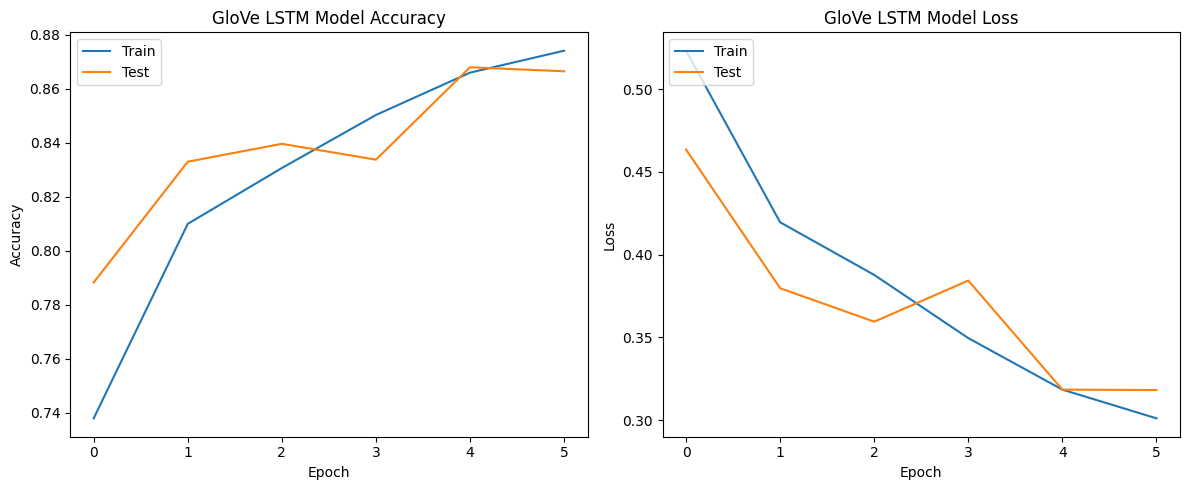

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axs[0].plot(glove_lstm_model_history.history['acc'])
axs[0].plot(glove_lstm_model_history.history['val_acc'])
axs[0].set_title('GloVe LSTM Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Loss plot
axs[1].plot(glove_lstm_model_history.history['loss'])
axs[1].plot(glove_lstm_model_history.history['val_loss'])
axs[1].set_title('GloVe LSTM Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Test'], loc='upper left')

# Improve layout
plt.tight_layout()
plt.show()

In [79]:
# Saving the model as a h5 file for possible use later

glove_lstm_model.save(f"./c1_glove_lstm_model_acc_{round(glove_LSTM_score[1], 3)}.h5", save_format='h5')

# 3(b). Recurrent Neural Network (LSTM) with Fasttext Embedding

In [81]:
fasttext_lstm_model = Sequential()
fasttext_lstm_model.add(Embedding(vocab_length, 300, weights=[fasttext_embedding_matrix], input_length=maxlen, trainable=False))
fasttext_lstm_model.add(LSTM(128))
fasttext_lstm_model.add(Dense(1, activation='sigmoid'))

fasttext_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [82]:
# Training Model
fasttext_lstm_model_history = fasttext_lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - acc: 0.6890 - loss: 0.5638 - val_acc: 0.8469 - val_loss: 0.3649
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.8503 - loss: 0.3590 - val_acc: 0.8584 - val_loss: 0.3299
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - acc: 0.8549 - loss: 0.3346 - val_acc: 0.8646 - val_loss: 0.3150
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - acc: 0.8629 - loss: 0.3240 - val_acc: 0.8719 - val_loss: 0.3044
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.8748 - loss: 0.3067 - val_acc: 0.8788 - val_loss: 0.2924
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - acc: 0.8804 - loss: 0.2962 - val_acc: 0.8776 - val_loss: 0.3098


In [83]:
fasttext_lstm_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (128, 100, 300)        │    27,718,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (128, 128)             │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,377,533 (108.25 MB)

 Trainable params: 219,777 (858.50 KB)

 Non-trainable params: 27,718,200 (105.74 MB)

 Optimizer params: 439,556 (1.68 MB)

In [84]:
# Predictions on the Test Set

fasttext_LSTM_score = fasttext_lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.8720 - loss: 0.3128


In [85]:
# Model Performance

print("Fasttext LSTM Test Score:", fasttext_LSTM_score[0])
print("Fasttext LSTM Test Accuracy:", fasttext_LSTM_score[1])

Fasttext LSTM Test Score: 0.312079519033432
Fasttext LSTM Test Accuracy: 0.8733000159263611


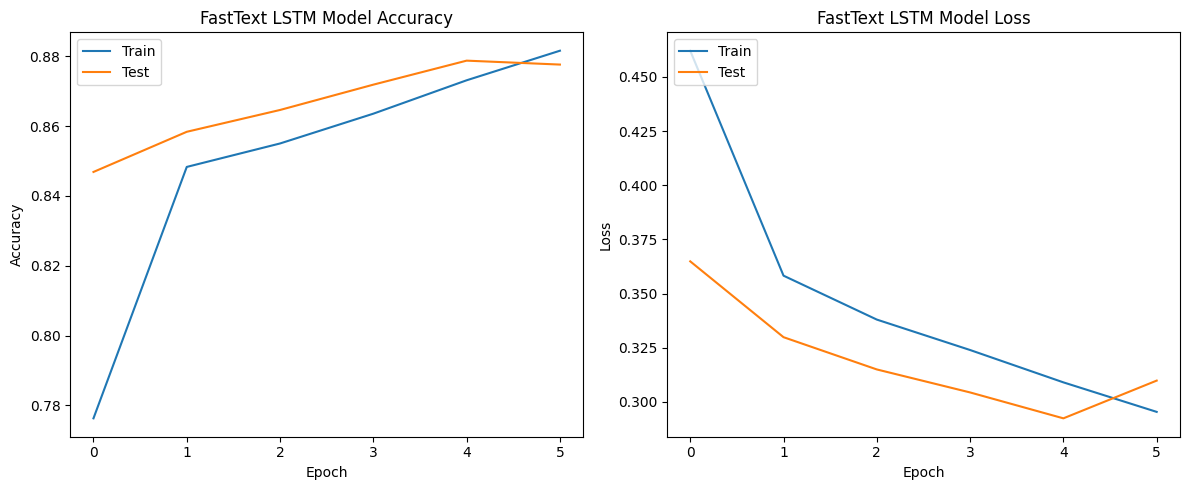

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axs[0].plot(fasttext_lstm_model_history.history['acc'])
axs[0].plot(fasttext_lstm_model_history.history['val_acc'])
axs[0].set_title('FastText LSTM Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Loss plot
axs[1].plot(fasttext_lstm_model_history.history['loss'])
axs[1].plot(fasttext_lstm_model_history.history['val_loss'])
axs[1].set_title('FastText LSTM Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Test'], loc='upper left')

# Layout adjustment
plt.tight_layout()
plt.show()

In [87]:
# Saving the model as a h5 file for possible use later

fasttext_lstm_model.save(f"./c2_fasttext_lstm_model_acc_{round(fasttext_LSTM_score[1], 3)}.h5", save_format='h5')

# Making Predictions on Live IMDb data

In [88]:
!ls # lists files in working directory

c1_glove_lstm_model_acc_0.864.h5     drive
c2_fasttext_lstm_model_acc_0.873.h5  sample_data


In [90]:
# Load previously trained LSTM Model

from tensorflow.keras.models import load_model

glove_pretrained_LSTM_model_path = '/content/c1_glove_lstm_model_acc_0.864.h5'
fasttext_pretrained_LSTM_model_path ='/content/c2_fasttext_lstm_model_acc_0.873.h5'

glove_pretrained_LSTM_model = load_model(glove_pretrained_LSTM_model_path)
fasttext_pretrained_LSTM_model = load_model(fasttext_pretrained_LSTM_model_path)



In [91]:
# summarize model.
glove_pretrained_LSTM_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (128, 100, 100)        │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (128, 128)             │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,356,779 (35.69 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

 Optimizer params: 2 (12.00 B)

In [92]:
# summarize model.
fasttext_pretrained_LSTM_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (128, 100, 300)        │    27,718,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (128, 128)             │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,937,979 (106.57 MB)

 Trainable params: 219,777 (858.50 KB)

 Non-trainable params: 27,718,200 (105.74 MB)

 Optimizer params: 2 (12.00 B)

In [93]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv(dataset_path)

sample_reviews.head(6)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive


In [94]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['review']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [95]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [96]:
# Passing tokenised instance to the GLOVE LSTM model for predictions
glove_unseen_sentiments = glove_pretrained_LSTM_model.predict(unseen_padded)

glove_unseen_sentiments

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


array([[0.651498  ],
       [0.92663604],
       [0.979756  ],
       ...,
       [0.31568652],
       [0.12732984],
       [0.02016243]], dtype=float32)

In [97]:
# Passing tokenised instance to the FASTTEXT LSTM model for predictions
fasttext_unseen_sentiments = fasttext_pretrained_LSTM_model.predict(unseen_padded)

fasttext_unseen_sentiments

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


array([[0.95816135],
       [0.9792723 ],
       [0.9758487 ],
       ...,
       [0.63869756],
       [0.03881   ],
       [0.01016528]], dtype=float32)

In [98]:
print('thanks')

thanks


# Final Evaluation

In [99]:
!pip install ace-tools


In [100]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from IPython.display import display

# 1. Map model names to your trained model objects
models = {
    'SNN_GloVe':        glove_snn_model,
    'SNN_FastText':     fasttext_snn_model,
    'CNN_GloVe':        glove_cnn_model,
    'CNN_FastText':     fasttext_cnn_model,
    'LSTM_GloVe':       glove_lstm_model,
    'LSTM_FastText':    fasttext_lstm_model
}

# 2. Compute metrics for each
rows = []
for name, m in models.items():
    # Predict probabilities and hard labels (use X_test_seq, y_test)
    probs = m.predict(X_test, verbose=0).ravel()
    preds = (probs >= 0.5).astype(int)

    rows.append({
        'Model':     name,
        'Accuracy':  accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall':    recall_score(y_test, preds),
        'F1 Score':  f1_score(y_test, preds),
        'ROC AUC':   roc_auc_score(y_test, probs)
    })

# 3. Build DataFrame
df_metrics = pd.DataFrame(rows).set_index('Model')

# 4. Display the results
display(df_metrics)


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
SNN_GloVe,0.7511,0.740203,0.779718,0.759447,0.824062
SNN_FastText,0.8171,0.803632,0.843024,0.822857,0.895609
CNN_GloVe,0.8468,0.886830,0.797777,0.839950,0.930718
CNN_FastText,0.8819,0.867849,0.903155,0.885150,0.952712
LSTM_GloVe,0.8638,0.870890,0.856718,0.863745,0.938496
LSTM_FastText,0.8733,0.865787,0.885890,0.875723,0.945726


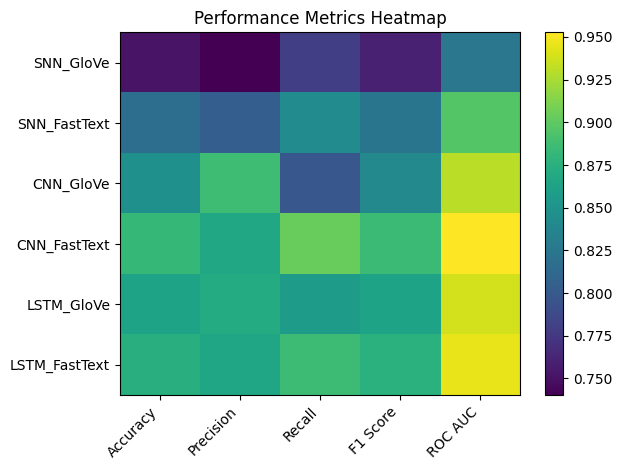

In [101]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
import matplotlib.pyplot as plt

# Recompute df_metrics if needed
models = {
    'SNN_GloVe':    glove_snn_model,
    'SNN_FastText': fasttext_snn_model,
    'CNN_GloVe':    glove_cnn_model,
    'CNN_FastText': fasttext_cnn_model,
    'LSTM_GloVe':   glove_lstm_model,
    'LSTM_FastText': fasttext_lstm_model
}

rows = []
for name, m in models.items():
    probs = m.predict(X_test, verbose=0).ravel()
    preds = (probs >= 0.5).astype(int)
    rows.append({
        'Model':     name,
        'Accuracy':  accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall':    recall_score(y_test, preds),
        'F1 Score':  f1_score(y_test, preds),
        'ROC AUC':   roc_auc_score(y_test, probs)
    })

df_metrics = pd.DataFrame(rows).set_index('Model')

# Plot heatmap
metrics = df_metrics.columns.tolist()
models = df_metrics.index.tolist()
data = df_metrics.values

plt.imshow(data, aspect='auto')
plt.colorbar()
plt.xticks(np.arange(len(metrics)), metrics, rotation=45, ha='right')
plt.yticks(np.arange(len(models)), models)
plt.title('Performance Metrics Heatmap')
plt.tight_layout()
plt.show()
